In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time
import csv
from scipy import stats
from numpy import genfromtxt
from scipy import signal
from scipy.fft import fft, fftfreq, ifft, next_fast_len
import pickle
from scipy.signal import blackman

In [2]:
roots = "D:/Dropbox/Doutorado/Jupyter/GitHub/ADCP_Shear_SSC_Rouse/Raw_Data/"

names = "LPboia02."
extensions = ['sen', 'v1', 'v2', 'v3', 'a1', 'a2', 'a3'
, 'wap', 'whd']
for ext in extensions:
    
    arq = np.loadtxt (roots + names + ext)
    
    globals()[ext] = arq    

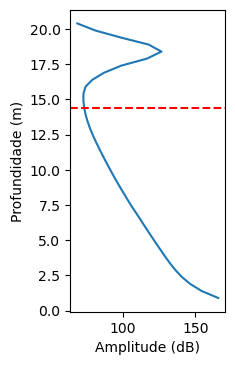

In [3]:
#Definindo a linha de corte para os dados de vel. e amplitude acústica:
z = np.array([0.90,1.40,1.90,2.40,2.90,3.40,3.90,4.40,4.90,5.40,5.90,6.40,6.90,7.40,7.90,8.40,8.90,9.40,9.90,10.40,10.90,11.40,11.90,12.40,12.90,13.40,13.90,14.40,14.90,15.40,15.90,16.40,16.90,17.40,17.90,18.40,18.90,19.40,19.90,20.40])
amp = (a1 + a2 + a3)/3
fig, ax = plt.subplots(figsize=(2,4), dpi = 100)
ax.plot(np.nanmean(amp, axis = 0),z)
plt.axhline(y=14.4, color='r', linestyle='--')
plt.ylabel('Profundidade (m)')
plt.xlabel("Amplitude (dB)")

v1_cut = np.delete(v1, slice(28,40), axis=1)
v2_cut = np.delete(v2, slice(28,40), axis=1)
v3_cut = np.delete(v3, slice(28,40), axis=1)
a1_cut = np.delete(a1, slice(28,40), axis=1)
a2_cut = np.delete(a2, slice(28,40), axis=1)
a3_cut = np.delete(a3, slice(28,40), axis=1)


Text(0.5, 0, 'Amplitude (dB)')

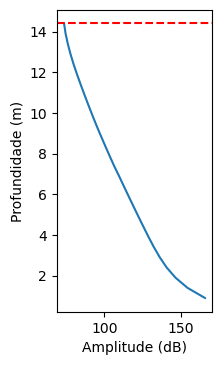

In [4]:
amp = (a1_cut + a2_cut + a3_cut)/3
z = np.array([0.90,1.40,1.90,2.40,2.90,3.40,3.90,4.40,4.90,5.40,5.90,6.40,6.90,7.40,7.90,8.40,8.90,9.40,9.90,10.40,10.90,11.40,11.90,12.40,12.90,13.40,13.90,14.40])

fig, ax = plt.subplots(figsize=(2,4), dpi = 100)


ax.plot(np.nanmean(amp, axis = 0),z)
plt.axhline(y=14.4, color='r', linestyle='--')
plt.ylabel('Profundidade (m)')
plt.xlabel("Amplitude (dB)")

In [5]:
time = []
time_II = []
db = sen[:,13] #pressao
depth = ((db*10000)/(1021.32*9.79499))

for i in range(len(sen[:,2])):
    tsh_tempo = datetime.datetime(int(sen[i,2]),
                                 int(sen[i,0]),
                                 int(sen[i,1]),
                                 int(sen[i,3]),
                                 int(sen[i,4]),
                                 int(sen[i,5]))
    tsh_tempo_II = datetime.datetime.timestamp(tsh_tempo)# Converti pra timestamp pra poder interpolar.
    time.append(tsh_tempo)
    time_II.append(tsh_tempo_II)

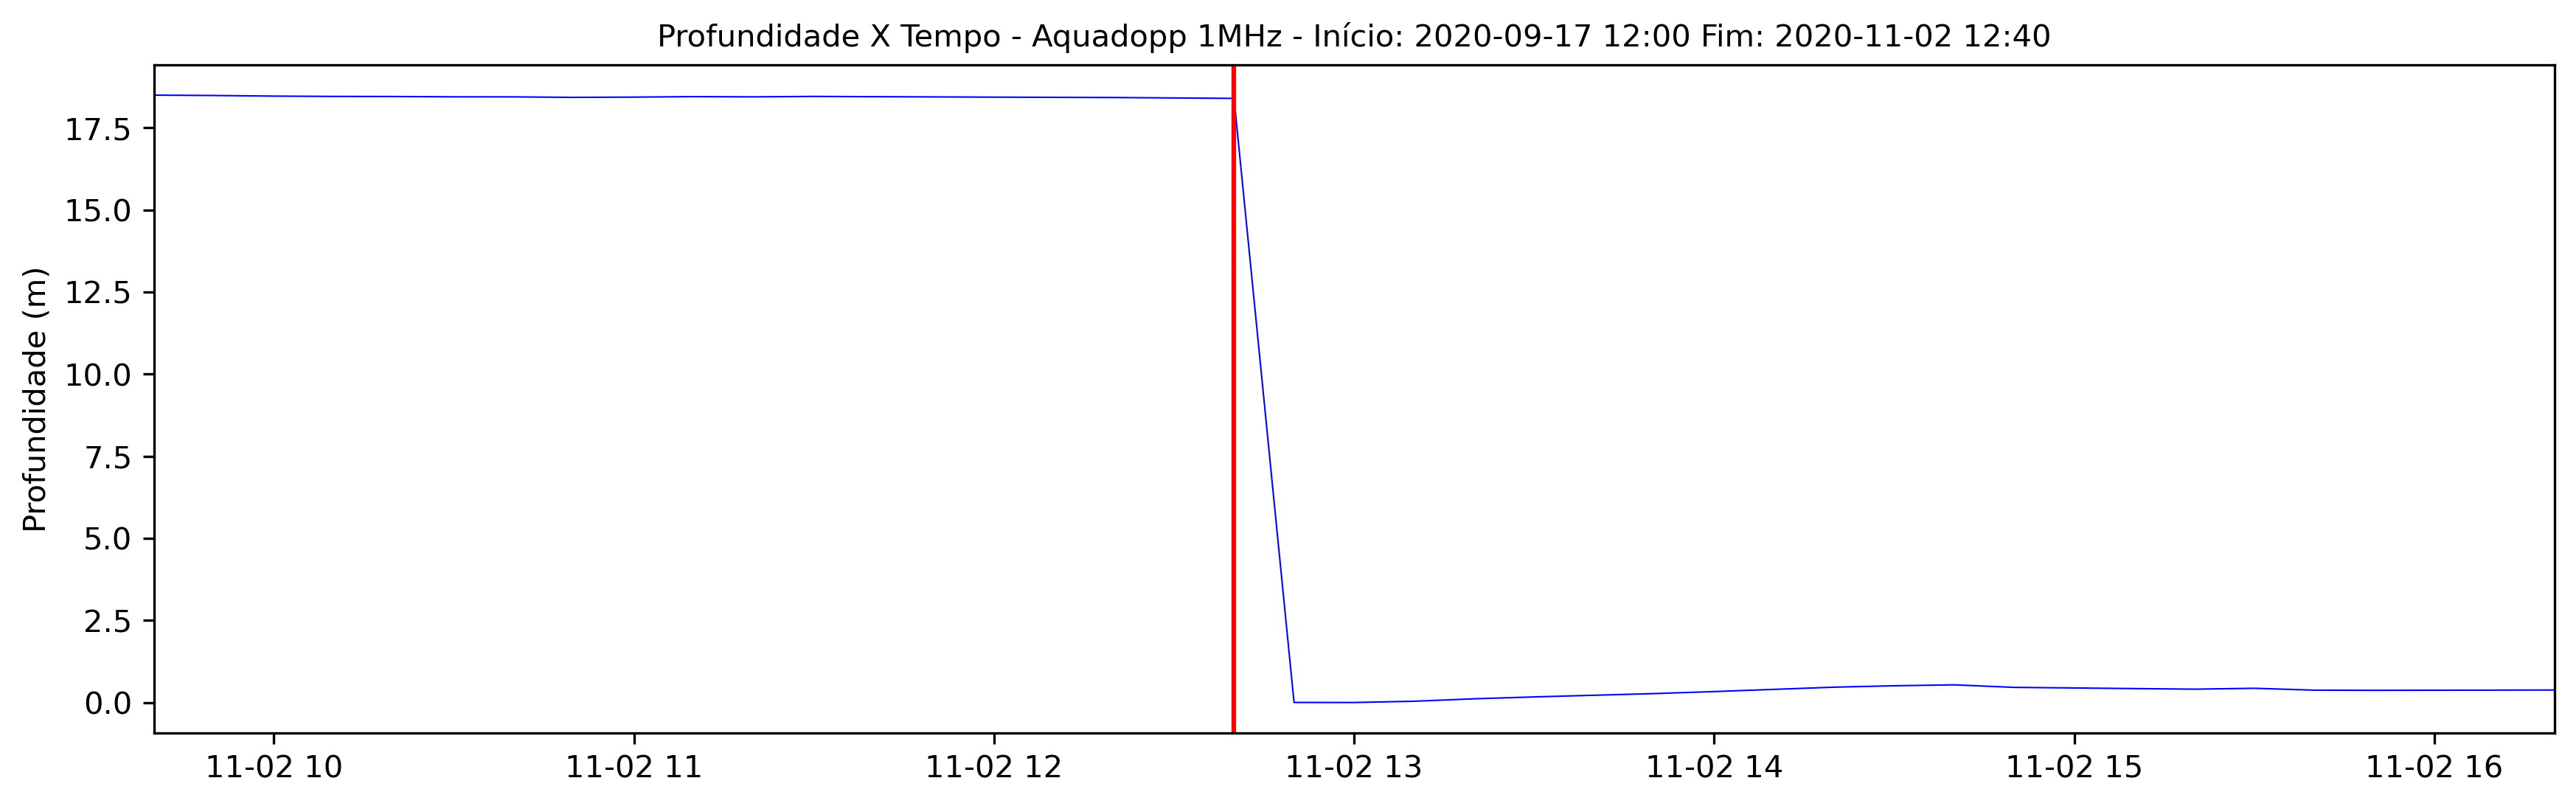

In [7]:
#Definindo o tempo de corte. A partir do índice 6628 o ADCP estava fora d'água.

fig, ax = plt.subplots(figsize=(14,4), dpi = 300)
ax.plot(time[6610:6651], depth[6610:6651], color  = 'b', linewidth = 0.5)
plt.title("Profundidade X Tempo - Aquadopp 1MHz - Início: 2020-09-17 12:00 Fim: 2020-11-02 12:40", fontsize=10)
ax.set_ylabel('Profundidade (m)')
ax.set_xlim(np.nanmin(time[6610:6651]), np.nanmax(time[6610:6651]))
ax.axvline(x = time[6628], color='r')

In [8]:
#Rotacionando os dados de vel. em 29 graus.
M = np.sqrt(v1_cut**2+v2_cut**2)
UV_dir = np.arctan2(v2_cut/M, v1_cut/M) 
UV_dir_degrees = UV_dir * 180/np.pi 

np.shape(UV_dir_degrees)          

U_spin = np.zeros((len(M), len(z[:])))
V_spin = np.zeros((len(M), len(z[:])))


for i in range(len(z[0:28])):
    for j in range(len(M)):
        if (M[j,i] != 0):
            U_spin[j,i] = M[j,i]*np.cos(UV_dir[j,i]-np.radians(29))
            V_spin[j,i] = M[j,i]*np.sin(UV_dir[j,i]-np.radians(29))

C:\Users\guioc\AppData\Local\Temp\ipykernel_13956\866010315.py:3: RuntimeWarning: invalid value encountered in true_divide
  UV_dir = np.arctan2(v2_cut/M, v1_cut/M)


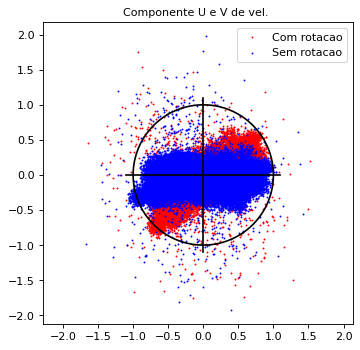

In [9]:
#Comparando os dados de vel. brutos com os dados rotacionados. 

fig, ax = plt.subplots(figsize=(5,5), dpi = 80)
n = np.linspace(0, 2*np.pi, 100)
circ_x = np.sin(n)
circ_y = np.cos(n)
ax.plot(circ_x, circ_y,'k')
ax.plot([0,0], [-1.1, 1.1], 'k')
ax.plot([-1.1, 1.1], [0, 0], 'k')
ax.axis('equal')
M = np.sqrt(V_spin**2+U_spin**2)
plt.title("Componente U e V de vel. ", fontsize=10)
ax.scatter(v1_cut,v2_cut,c = 'r',cmap=plt.cm.jet, s = 0.5, label = 'Com rotacao')
ax.scatter(U_spin,V_spin,c = 'b',cmap=plt.cm.jet, s = 0.5, label = 'Sem rotacao')
ax.legend()

In [10]:
#Convertendo a amplitude acústica obtida pelo ADCP para retroespalhamento acústico
#Ref: 10.1016/j.margeo.2004.07.001
amp = (a1_cut + a2_cut + a3_cut)/3
deg_sensor = 25 #angulo do feixe acustico em relação à vertical
dist_feixe = z/np.cos(deg_sensor*np.pi/180)
alpha = 0.34 #http://resource.npl.co.uk/acoustics/techguides/seaabsorption/
correcao_geometrica = 20*np.log10(dist_feixe)
correcao_absorcao = 2*alpha*dist_feixe
# retro-espalhamento acústico (dB) ou acoustic backscatter
rea = 0.42*(amp - 20) + correcao_geometrica + correcao_absorcao

#Calibração obtida do artigo (Schettini 2013).
#Ref: https://doi.org/10.1016/j.csr.2013.03.006
ssc = -1.05+1.03*np.exp(-7.608+0.1989*rea)

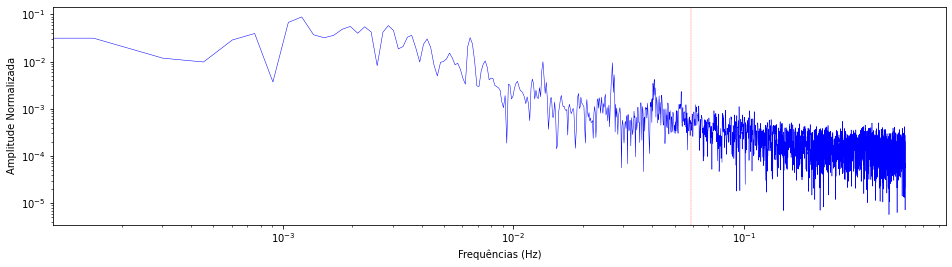

In [11]:
#Definindo a frequência de corte para o filtro de FFT.

trashU = np.nanmean(U_spin[0:6628], 1)

n = len(trashU)#potencia de dois sempre 2-4-6 aconselhavel
w = blackman(n)

t = 1

yf = fft(trashU*w)
xf = fftfreq(n, t)


yf = yf[0:n//2]
xf = xf[:n//2]

yf = 2.0/n * np.abs(yf)


plt.figure(figsize=(16,4))
plt.loglog((xf),(yf), color = 'b', linewidth = 0.5)
plt.xlabel('Frequências (Hz)')
plt.ylabel('Amplitude Normalizada')
plt.axvline(x= 1/17, color='r', linestyle='--', linewidth = 0.3)

In [12]:
fs = 1  #frequencia amostral = foi realizada coletas a cada um segundo
fc = 1/17  # Cut-off frequency of the filter (frequencia de corte)
w = fc / (fs / 2) # Normalize the frequency

b, a = signal.butter(5, w, 'low') 


U_fft = np.zeros((len(time[0:6628]), len(z)))

for i in range(len(z[0:28])):
    U_fft[:,i] = signal.filtfilt(b, a, U_spin[0:6628, i])

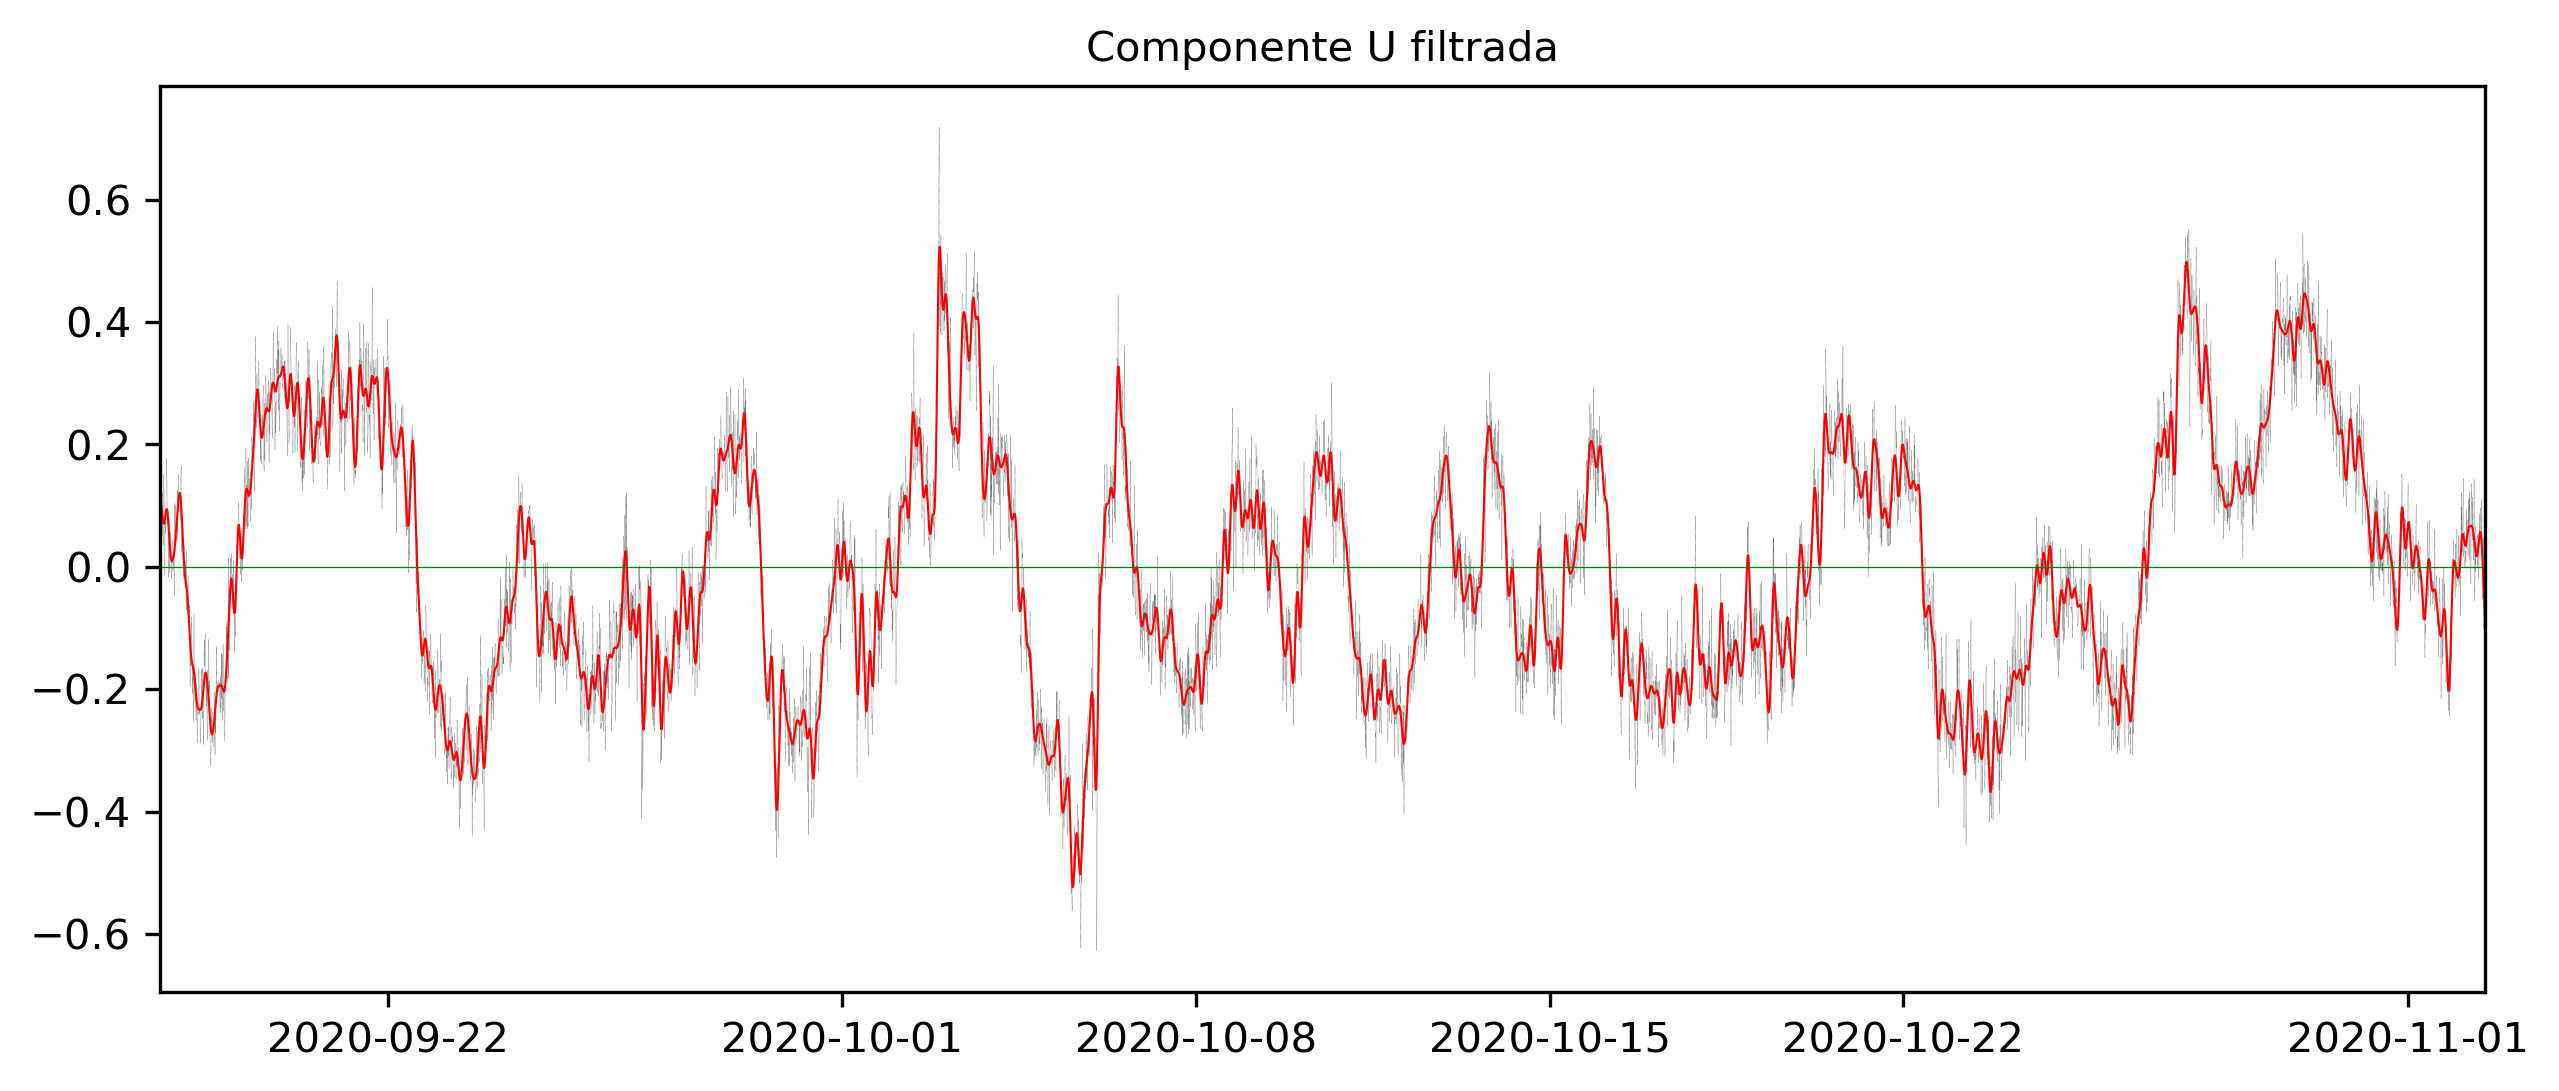

In [13]:
fig, ax = plt.subplots(figsize=(10,4), dpi = 300)

plt.title("Componente U filtrada", fontsize=10)
ax.plot(time[0:6628],U_spin[0:6628,0],':',linewidth = 0.1, color = 'k')
ax.plot(time[0:6628],U_fft[:,0],linewidth = 0.5,color =  'r')
ax.set_xlim(np.min(time[0:6628]), np.max(time[0:6628]))
plt.axhline(y= 0, color='g', linewidth = 0.3)

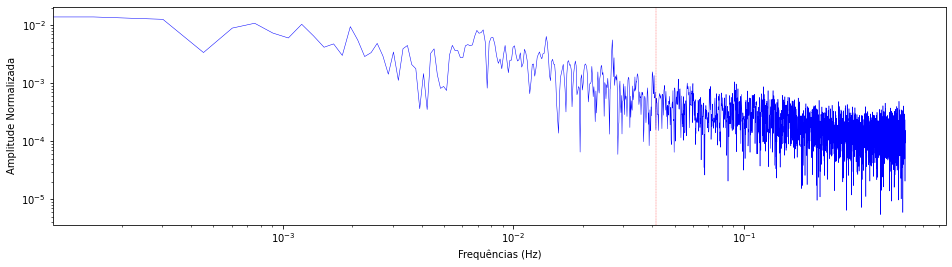

In [14]:
#Definindo a frequência de corte para o filtro de FFT.

trashV = np.nanmean(V_spin[0:6628], 1)

n = len(trashV)#potencia de dois sempre 2-4-6 aconselhavel
w = blackman(n)

t = 1

yf = fft(trashV*w)
xf = fftfreq(n, t)


yf = yf[0:n//2]
xf = xf[:n//2]

yf = 2.0/n * np.abs(yf)


plt.figure(figsize=(16,4))
plt.loglog((xf),(yf), color = 'b', linewidth = 0.5)
plt.xlabel('Frequências (Hz)')
plt.ylabel('Amplitude Normalizada')
plt.axvline(x= 1/24, color='r', linestyle='--', linewidth = 0.3)

In [15]:
fs = 1  #frequencia amostral = foi realizada coletas a cada um segundo
fc = 1/24  # Cut-off frequency of the filter (frequencia de corte)
w = fc / (fs / 2) # Normalize the frequency

b, a = signal.butter(5, w, 'low')   #o que representa o 5?  'low' seria para passar apenas abaixo da frequencia de corte?


V_fft = np.zeros((len(time[0:6628]), len(z)))

for i in range(len(z[0:28])):
    V_fft[:,i] = signal.filtfilt(b, a, V_spin[0:6628, i])

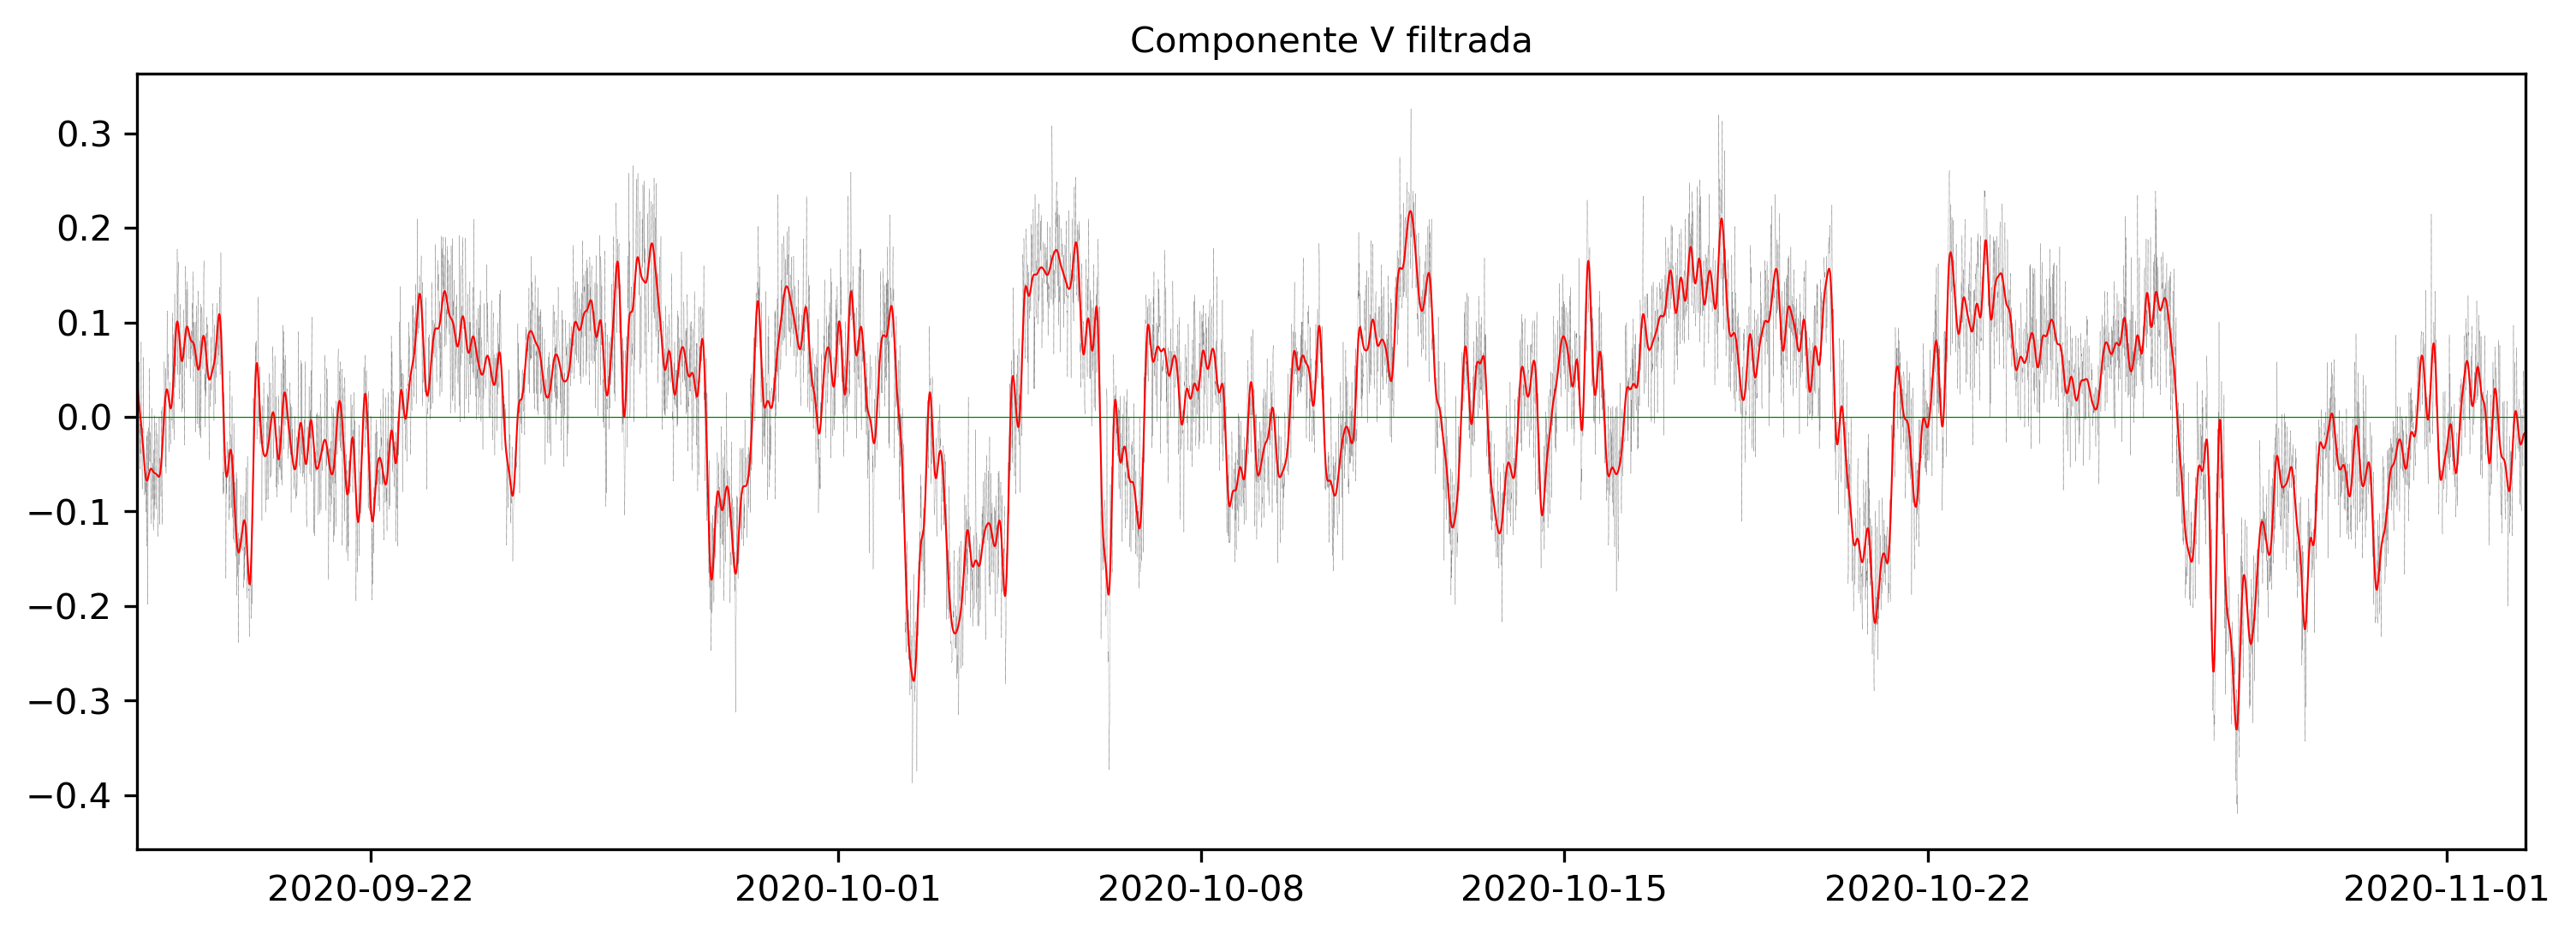

In [16]:
fig, ax = plt.subplots(figsize=(12,4), dpi = 300)

plt.title("Componente V filtrada", fontsize=10)
ax.plot(time[0:6628],V_spin[0:6628,0],':',linewidth = 0.1, color = 'k')
ax.plot(time[0:6628],V_fft[:,0],linewidth = 0.5,color =  'r')
ax.set_xlim(np.min(time[0:6628]), np.max(time[0:6628]))
plt.axhline(y= 0, color='g', linewidth = 0.3)

In [17]:
#Salvando os dados processados
roots = "D:/Dropbox/Doutorado/Jupyter/GitHub/ADCP_Shear_SSC_Rouse/Output_Data/"

with open(roots+'U_fft.pkl', 'wb') as file:
    pickle.dump(U_fft, file)
    
with open(roots+'V_fft.pkl', 'wb') as file:
    pickle.dump(V_fft, file)
    
with open(roots+'U_raw.pkl', 'wb') as file:
    pickle.dump(U_spin[0:6628,:], file)
    
with open(roots+'V_raw.pkl', 'wb') as file:
    pickle.dump(V_spin[0:6628,:], file)

with open(roots+'Time_fft.pkl', 'wb') as file:
    pickle.dump(time[0:6628], file)
    
with open(roots+'Time_II_fft.pkl', 'wb') as file:
    pickle.dump(time_II[0:6628], file)
    
with open(roots+'REA.pkl', 'wb') as file:
    pickle.dump(rea[0:6628], file)

with open(roots+'SSC_rea.pkl', 'wb') as file:
    pickle.dump(ssc[0:6628], file)

with open(roots+'depth.pkl', 'wb') as file:
    pickle.dump(depth[0:6628], file)